In [1]:
import re
import html
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../src")
import config


Data Exploration
Exploring the dataset structure, labels, and text characteristics

In [2]:
def analyze_data_frame(df, text_col = 'text'): 
    
    df.info()
    df.describe()
    text_length = df[text_col].str.len()
    text_lengths = text_length.value_counts().sort_index()


    text_lengths.plot(kind='line', figsize=(12, 5))
    plt.xlabel("Text length (in characters)")
    plt.ylabel("Number of samples")
    plt.title("Distribution of text lengths")
    plt.show()
    
    print(f"The maximum length of a review is {text_length.max()} characters.")
    print(f"The minimum length of a review is {text_length.min()} characters.")
    print(f"The average length of a review is {text_length.mean():.2f} characters.")
    print(f"The standard deviation of the length of reviews is {text_length.std():.2f} characters.")
    print(f"The median length of a review is {text_length.median()} characters.")

In [3]:
def clean_and_reshap(df, text_col='text', label_col='label', positive_label_val=1):

    has_label = label_col in df.columns

    if has_label:
        df = df.dropna(subset=[label_col])

    # ---- text cleaning ----
    def clean_review(text):
        if not isinstance(text, str):
            text = ""
        text = html.unescape(text)
        text = re.sub(r'<br\s*/?>', '\n', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        return text.strip()

    df[text_col] = df[text_col].astype(str).apply(clean_review)
    df = df.dropna(subset=[text_col])
    df = df[df[text_col].str.strip() != ""]

    # ---- remove conflicting labels ----
    if has_label:
        def remove_conflicting_labels(df, text_col, label_col):
            label_counts = df.groupby(text_col)[label_col].nunique()
            conflicted_texts = label_counts[label_counts > 1].index
            return df[~df[text_col].isin(conflicted_texts)].reset_index(drop=True)

        df = remove_conflicting_labels(df, text_col, label_col)

        # convert labels
        df[label_col] = (df[label_col] == positive_label_val).astype(int)

        # keep only columns we need
        df = df[[text_col, label_col]]
        
        df = df.rename(columns={label_col: "label"})
    else:
        df = df[[text_col]]

    # rename column
    df = df.rename(columns={text_col: "text"})

    print(f"Number of records after cleaning: {len(df)}")

    if has_label:
        print("Label distribution:")
        print(df['label'].value_counts(), "\n")

    return df


In [4]:
def analyze_vocabulary_coverage(text_df,top_n=10000,coverage_threshold=50.0):
    """
    Analyzes vocabulary coverage on a dataset by computing the frequency of all tokens,
    extracting the top-N most frequent words, and plotting the cumulative token coverage
    from the specified threshold up to 100%.
    Parameters
    ----------
    text_df : Iterable[str]
        A collection of text samples.
    top_n : int, default=10000
        Number of most frequent words to include in the coverage calculation.
    coverage_threshold : float, default=50.0
        Minimum percentage of token coverage to display in the plot.
    """

    tokens = []
    for text in text_df:
        tokens.extend(text.split())

    word_counts = Counter(tokens)
    print(f"Total unique word types (vocabulary size): {len(word_counts)}")

    most_common_words = word_counts.most_common(top_n)
    vocab, freqs = zip(*most_common_words)

    total_tokens = sum(word_counts.values())
    cumulative_freqs = np.cumsum(freqs)
    coverage = cumulative_freqs / total_tokens * 100

    mask = coverage >= coverage_threshold
    coverage_filtered = coverage[mask]
    x_indices = np.arange(1, len(coverage)+1)[mask]

    plt.figure(figsize=(10,6))
    plt.plot(x_indices, coverage_filtered)
    plt.xlabel("Number of most frequent words")
    plt.ylabel("Coverage (%)")
    plt.title("Vocabulary Coverage Curve")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

IMDB - EDA & Data Preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


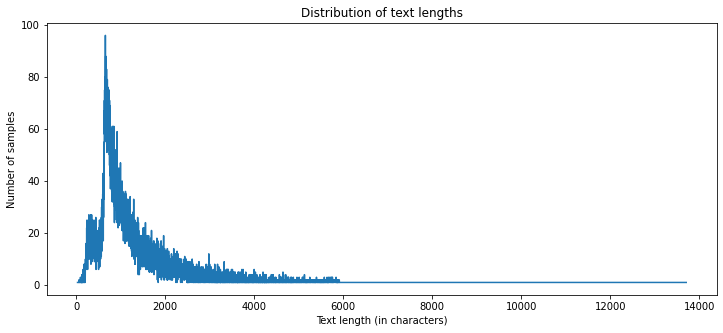

The maximum length of a review is 13704 characters.
The minimum length of a review is 32 characters.
The average length of a review is 1309.43 characters.
The standard deviation of the length of reviews is 989.73 characters.
The median length of a review is 970.0 characters.
Number of records after cleaning: 50000
Label distribution:
label
1    25000
0    25000
Name: count, dtype: int64 

Total unique word types (vocabulary size): 167237


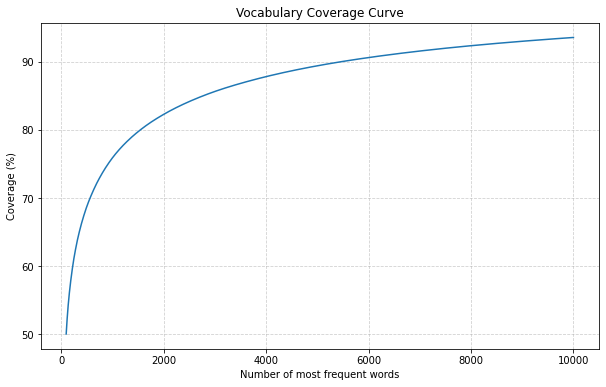

In [5]:
df_imdb = pd.read_csv(config.IMDB_PATH)
analyze_data_frame (df_imdb, text_col='review')
df_imdb = clean_and_reshap(df_imdb, text_col='review', label_col='sentiment', positive_label_val='positive')
analyze_vocabulary_coverage(df_imdb['text'],top_n=10000,coverage_threshold=50.0)

In [6]:
df_imdb_train, df_imdb_test = train_test_split(
    df_imdb,
    test_size=0.2,
    random_state=42,
    stratify=df_imdb['label']
)

In [7]:
df_imdb_train.to_csv(config.IMDB_TRAIN_PATH, index=False)
df_imdb_test.to_csv(config.IMDB_TEST_PATH, index=False)

Rotten Tomatoes - EDA & Data Preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10662 non-null  object
 1   sentiment  10662 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 166.7+ KB


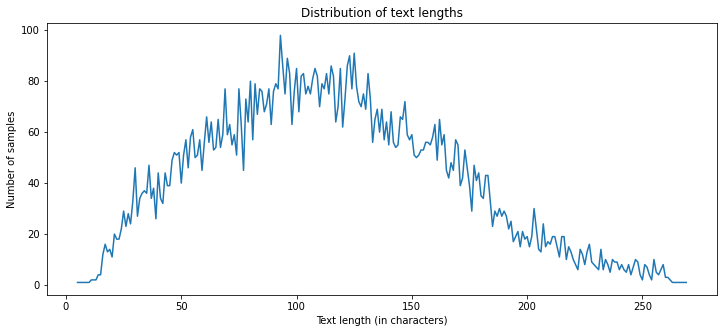

The maximum length of a review is 269 characters.
The minimum length of a review is 5 characters.
The average length of a review is 115.16 characters.
The standard deviation of the length of reviews is 51.20 characters.
The median length of a review is 112.0 characters.
Number of records after cleaning: 10662
Label distribution:
label
0    5331
1    5331
Name: count, dtype: int64 

Total unique word types (vocabulary size): 20490


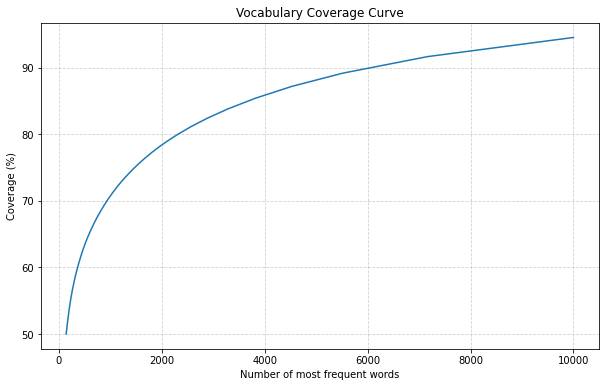

In [8]:
df_rt = pd.read_csv(config.RT_PATH)
analyze_data_frame (df_rt, text_col='review',)
df_rt = clean_and_reshap(df_rt, text_col='review', label_col='sentiment', positive_label_val=1)
analyze_vocabulary_coverage(df_rt['text'],top_n=10000,coverage_threshold=50.0)

In [9]:
df_rt_train, df_rt_test = train_test_split(
    df_rt,
    test_size=0.2,
    random_state=42,
    stratify=df_rt['label']
)

In [10]:
df_rt_train.to_csv(config.RT_TRAIN_PATH, index=False)
df_rt_test.to_csv(config.RT_TEST_PATH, index=False)

Clean imdb Unsuperwised dataset

In [11]:
df_imdb_unsuperwised = pd.read_csv(config.IMDB_UNSUPERVISED_PATH)
df_imdb_unsuperwised = clean_and_reshap(df_imdb_unsuperwised, text_col='review')

Number of records after cleaning: 50000


In [12]:
df_imdb_unsuperwised.to_csv(config.IMDB_UNSUPERVISED_CLEAN_PATH, index=False)